In [4]:
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import convolve2d
from skimage.measure import EllipseModel
from skimage.measure import label as ConnectRegion
from astropy.cosmology import Planck18
from matplotlib.patches import Ellipse
from astropy.coordinates import SkyCoord
from skimage import measure
from scipy.signal import find_peaks

from scipy.ndimage import gaussian_filter

import ztfidr
import galaxy_phot as glp

warnings.filterwarnings('ignore')

In [5]:
importlib.reload(glp)
sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

conds1 = (sample.data['redshift'] > 0 ) & (sample.data['redshift'] < 0.2) 
conds2 = np.intersect1d(host_data.index, sample.data.index)
data = host_data[['host_ra', 'host_dec']].loc[conds2].dropna()[conds1]
targets = data.index
len(data)

3613

In [3]:
class galaxy_decomp:
    def __init__(self, sn_name, verbose, band, source='save'):
        self.verbose = verbose
        self.gobj = glp.HostGal(verbose=verbose)
        self.gobj.init_dr2(sn_name, sample, host_data)
        self.gobj.get_image(source=source, survey='auto', output_='z', band=band, scale=0.262, soft=True)

    def plot_fit(self, results, px_fits, objects):
        fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), dpi=100, ncols=2)
        mag, wcs = self.gobj.cutout['mag'], self.gobj.cutout['wcs']
        ax2.imshow(mag, cmap='gray', origin='lower')
        colors2 = ['red', 'blue', 'orange', 'yellow']
        colors1a = ['maroon', 'red', 'orange', 'yellow']
        colors1b = ['lime', 'green', 'cyan', 'blue']
        (sn_ra, sn_dec) = self.gobj.gal['sn']
        c = SkyCoord(ra=sn_ra*u.degree, dec=sn_dec*u.degree, frame='icrs')
        sn_px = wcs.world_to_pixel(c)
        ax2.scatter(sn_px[0], sn_px[1], c='cyan', s=40, lw=2, fc='None', ec='cyan')
        if np.any(objects):
            ax1.plot(objects[0], objects[1], 'k.', ms=5, label='masks')
            mask=30
            for (x_, y_) in objects.T:
                circ_patch = Ellipse((x_, y_), mask, mask, 0, edgecolor='black', facecolor='black',zorder=10)
                ax1.add_patch(circ_patch)
        for i, res_ in enumerate(results):
            xc, yc, a, b, theta, res, window, iso = res_
            norm = np.stack(np.where((mag.T > iso-0.1) & (mag.T < iso+0.1))).T
            px_red, px_fit, residuals = px_fits[i]
            ax2.scatter(norm.T[0], norm.T[1], color=colors2[i], s=1, marker='o', zorder=0, label=f'{iso:.0f}')
            if np.any(px_fit):
                ax1.scatter(px_fit.T[0], px_fit.T[1], color=colors1b[i], s=1, marker='o', zorder=1, label=f'{iso:.0f} fitted')
            if np.any(px_red):
                ax1.scatter(px_red.T[0], px_red.T[1], color=colors1a[i], s=1, marker='o',zorder=0, label=f'{iso:.0f} removed')
           
            if xc == 0:
                continue
            else:
                ell_patch1 = Ellipse((xc, yc), 2*a, 2*b, np.rad2deg(theta), edgecolor='black', facecolor='none')
                ax1.add_patch(ell_patch1)
                ell_patch2 = Ellipse((xc, yc), 2*a, 2*b, np.rad2deg(theta), edgecolor='lime', facecolor='none')
                ax2.add_patch(ell_patch2)

                ax1.set_xlim(*ax2.get_xlim())
                ax1.set_ylim(*ax2.get_ylim())
        ax1.legend(framealpha=0.8, markerscale=5)
        ax2.legend(framealpha=1, markerscale=5)
        plt.tight_layout()
        return ax1, ax2

    @staticmethod
    def prep_pixels(img, isophote, blur, object_masks=[]):
        kernal5 = np.array([[ 0,  0,  1,  1,  1],
                            [ 0,  0,  0,  1,  1],
                            [-1,  0,  0,  0,  1],
                            [-1, -1,  0,  0,  0],
                            [-1, -1, -1,  0,  0]])

        kernal_ = 1/(kernal5 + isophote)
        kernal_unit = kernal_ / np.sum(kernal_)
        conv_blur = gaussian_filter(img, sigma=blur)
        convolve_1 = convolve2d(conv_blur, kernal_unit, mode='same')
        convolve_2 = convolve2d(convolve_1, kernal_unit[::-1], mode='same')

        convolve_2[:5,:] = 0
        convolve_2[-5:,:] = 0
        convolve_2[:,:5] = 0
        convolve_2[:,-5:] = 0

        if np.any(object_masks):
            for (x_, y_) in object_masks.T:
                Y, X = np.ogrid[:len(img), :len(img)]
                dist_from_center = np.sqrt((X - x_)**2 + (Y - y_)**2)
                mask = dist_from_center >= 30/2
                convolve_2 = convolve_2 * mask
                
        return convolve_2

    @staticmethod
    def window_optimise(pixels, isophote):
        for wi in np.arange(0.1, 0.55, 0.1): 
            contour = np.stack(np.where((pixels.T > isophote-wi) & (pixels.T < isophote+wi)))
            if len(contour.T) > 1000:
                break
        return contour.T, wi
    
    def get_target_pixels(self, img, data, near=0):
        binary_image = np.zeros_like(img, dtype=np.uint8)
        binary_image[data.T[0], data.T[1]] = 1
        connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
        
        region_count = np.asarray(np.unique(connect_, return_counts=True))
        n_biggest = -np.arange(2, min(len(region_count[1])+1, 6))
        largest_regions = np.partition(region_count[1], n_biggest)[n_biggest]
        largest_regions = largest_regions[largest_regions > 10]
        # print(largest_regions) if self.verbose else None

        def get_pixels(count_):
            return np.stack(np.where(connect_ == np.where(region_count[1] == count_)[0]))

        def region_loc(count_):
            region_i = get_pixels(count_)
            return np.sum((region_i.mean(axis=1) - len(connect_)//2)**2)

        if len(largest_regions) != 0:
            arg_ = np.argpartition(np.vectorize(region_loc)(largest_regions), near)[near]
            return get_pixels(largest_regions[arg_]).T
        else:
            return []
    
    def ellipse_fit(self, data):
        px_d = data[::max(len(data)//1000, 1)]
        ell = EllipseModel()
        ell.estimate(px_d)
        if ell.params is None:
            print('no fit') if self.verbose else None
            return (0,0,0,0,0), 0
        else:
            res = ell.residuals(px_d)
            return ell.params, res
        
    def contour_fit(self, isophote, object_masks, blur):
        full_image = self.gobj.cutout['mag']
        filtered_image = self.prep_pixels(full_image, isophote, blur, object_masks)
        all_pixels, fit_window = self.window_optimise(filtered_image, isophote)
        fit_pixels = self.get_target_pixels(full_image, all_pixels)
        if len(fit_pixels) != 0:
            params, residuals = self.ellipse_fit(fit_pixels)
            chi2 = np.sum(residuals**2)/(len(residuals)-len(params))
        else:
            print('no data') if self.verbose else None
            params, chi2, residuals = (0,0,0,0,0), 0, []
        xc, yc, a, b, theta = params
        return [xc, yc, a, b, theta, chi2, fit_window, isophote], [all_pixels, fit_pixels, residuals]

    def residual_optimise(self):
        # iteratively cut residuals, to remove blobs
        pass

    def true_isophote_correction(self):
        # correct fit using real iophote pixels
        pass

    def astro_object_mask(self, iso_targets):
        # detect stars, galaxies that contaminate the image so they can be removed effectively
        # correct host identification
        full_image = self.gobj.cutout['mag']
        center_ = np.zeros((len(iso_targets), 4))
        for i, iso_i in enumerate(iso_targets):
            
            filtered_image = self.prep_pixels(full_image, iso_i, blur=1)
            all_pixels, fit_window = self.window_optimise(filtered_image, iso_i)

            fit_pixels_1 = self.get_target_pixels(full_image, all_pixels, near=1)
            params1, residuals1 = self.ellipse_fit(fit_pixels_1)

            fit_pixels_2 = self.get_target_pixels(full_image, all_pixels, near=2)
            params2, residuals2 = self.ellipse_fit(fit_pixels_2)

            center_[i] = [params1[0], params1[1], params2[0], params2[1]]

        def get_object_centers(coords, proximity):
            c_coords = coords.reshape(-1, 2, 1)
            dists = np.sqrt(np.sum(np.square(c_coords - c_coords.T), axis=1))
            dists = np.triu(dists)
            dists[dists == 0] = 1000
            detect_object = np.where(dists<proximity)
            pair_1 = c_coords.T[0][:,detect_object[0]]
            pair_2 = c_coords.T[0][:,detect_object[1]]
            object_center = np.mean(np.stack([pair_1, pair_2]), axis=0) # need to account for >3 iso
            return object_center
        
        object_centers = get_object_centers(center_, proximity=5)
        return object_centers[:,1:-1]  # hotfix

    def fit_dim_isophotes(self):
        # fit isophtes where default kernal does not return enough points
        pass
    
    def flag_galaxy(self):
        # if all fits fail, flag galaxy
        pass

    def spiral_arms(self):
        # detect and fit spiral arms
        pass


    def main_run(self, mask):
        iso_targets = [24, 23, 22, 21]
        fit_params, fit_data = np.zeros((len(iso_targets), 8)), []
        if mask:
            object_masks = self.astro_object_mask(iso_targets)
        else:
            object_masks = []
        for i, isophote_i in enumerate(iso_targets):
            fit_p, fit_d = self.contour_fit(isophote_i, object_masks, blur=1)
            fit_params[i] = fit_p
            fit_data.append(fit_d)
        
        c_offset = np.sqrt((fit_params.T[0][:-1]-fit_params.T[0][1:])**2 + (fit_params.T[1][:-1]-fit_params.T[1][1:])**2)
        s_offset = fit_params.T[2][:-1]-fit_params.T[2][1:]
        fqc = c_offset/s_offset # fit quality criterion
        print(fqc) if self.verbose else None
        fqc_sign = np.sign(fqc)
        fqc_cut = np.log10(fqc) < 0.25

        return fit_params, fit_data, object_masks
    


In [36]:
class galaxy_decomp2:
    def __init__(self, sn_name, verbose, band, source='save'):
        self.verbose = verbose
        self.gobj = glp.HostGal(verbose=verbose)
        self.gobj.init_dr2(sn_name, sample, host_data)
        self.gobj.get_image(source=source, survey='auto', output_='z', band=band, scale=0.262)
        self.objects = {}

    def plot_fit(self, results, px_fits, objects):
        pass

    @staticmethod
    def prep_pixels(img, isophote, blur, window, object_masks=[]):
        kernal5 = np.array([[ 0,  0,  1,  1,  1],
                            [ 0,  0,  0,  1,  1],
                            [-1,  0,  0,  0,  1],
                            [-1, -1,  0,  0,  0],
                            [-1, -1, -1,  0,  0]])

        kernal_ = 1/(kernal5 + isophote)
        kernal_unit = kernal_ / np.sum(kernal_)
        conv_blur = gaussian_filter(img, sigma=blur)
        convolve_1 = convolve2d(conv_blur, kernal_unit, mode='same')
        convolve_2 = convolve2d(convolve_1, kernal_unit[::-1], mode='same')

        convolve_2[:5,:] = 0
        convolve_2[-5:,:] = 0
        convolve_2[:,:5] = 0
        convolve_2[:,-5:] = 0

        if np.any(object_masks):
            for (x, y, a, b, ang) in object_masks.T:
                Y, X = np.ogrid[:len(img), :len(img)]
                dist_from_center = np.sqrt((X - x)**2 + (Y - y)**2)
                mask = dist_from_center >= a
                convolve_2 = convolve_2 * mask

        contour = np.stack(np.where((convolve_2 > isophote-window) & (convolve_2 < isophote+window)))
        return contour.T

    def get_window(self):
        pass
    
    def get_target_pixels(self, img, data, near=0):
        binary_image = np.zeros_like(img, dtype=np.uint8)
        binary_image[data.T[0], data.T[1]] = 1
        connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
        
        region_count = np.asarray(np.unique(connect_, return_counts=True))
        n_biggest = -np.arange(2, min(len(region_count[1])+1, 6))
        largest_regions = np.partition(region_count[1], n_biggest)[n_biggest]
        largest_regions = largest_regions[largest_regions > 24]
        # print(largest_regions) if self.verbose else None

        def get_pixels(count_):
            return np.stack(np.where(connect_ == np.where(region_count[1] == count_)[0]))

        def region_loc(count_):
            region_i = get_pixels(count_)
            return np.sum((region_i.mean(axis=1) - len(connect_)//2)**2)

        if len(largest_regions) != 0:
            arg_ = np.argpartition(np.vectorize(region_loc)(largest_regions), near)[near]
            return get_pixels(largest_regions[arg_]).T
        else:
            return []
    
    def ellipse_fit(self, data):
        px_d = data[::max(len(data)//1000, 1)]
        ell = EllipseModel()
        ell.estimate(px_d)
        if ell.params is None:
            print('no fit') if self.verbose else None
            return (0,0,0,0,0), 0
        else:
            res = ell.residuals(px_d)
            return ell.params, res
        
    def contour_fit(self, isophote, window, blur):
        full_image = self.gobj.cutout['mag']
        all_pixels = self.prep_pixels(full_image, isophote, blur, object_masks=[])
     
        object_dict = self.get_target_pixels(full_image, all_pixels)
        return object_dict


        # if len(fit_pixels) != 0:
        #     params, residuals = self.ellipse_fit(fit_pixels)
        #     chi2 = np.sum(residuals**2)/(len(residuals)-len(params))
        # else:
        #     print('no data') if self.verbose else None
        #     params, chi2, residuals = (0,0,0,0,0), 0, []
        # xc, yc, a, b, theta = params
        # return [xc, yc, a, b, theta, chi2, fit_window, isophote], [all_pixels, fit_pixels, residuals]



    def main_run(self):
        for i, iso_i in np.arange(24, 17, -1):
            obj = self.contour_fit(iso_i, window=1, blur=1)
    

In [37]:
sn_name =  'ZTF20acwmpsj'
gd = galaxy_decomp2(sn_name, verbose=True, band='g', source='save')

ZTF20acwmpsj 122.91033 -2.3300799999999997 0.051820000000000005 z_gal
legacy 264 0.262


In [38]:
# obj_ = gd.main_run(mask=False)

In [6]:
sn_name =  'ZTF18aahfzea'#'ZTF20aaummmc' #'ZTF20acwmpsj' #'ZTF18abnxhmc' 
gd = galaxy_decomp(sn_name, verbose=True, band='g', source='save')

ZTF18aahfzea 181.361 20.303079999999998 0.02435577 z_gal
legacy 573 0.262


In [15]:
kernal5 = np.array([[ 0,  0,  1,  1,  1],
                            [ 0,  0,  0,  1,  1],
                            [-1,  0,  0,  0,  1],
                            [-1, -1,  0,  0,  0],
                            [-1, -1, -1,  0,  0]])

mag = gd.gobj.cutout['mag']
kernal_ = 1/(kernal5 + 23)
kernal_unit = kernal_ / np.sum(kernal_)
conv_blur = gaussian_filter(mag, sigma=1)
convolve_1 = convolve2d(conv_blur, kernal_unit, mode='same')
convolve_2 = convolve2d(convolve_1, kernal_unit[::-1], mode='same')

convolve_2[:5,:] = 0
convolve_2[-5:,:] = 0
convolve_2[:,:5] = 0
convolve_2[:,-5:] = 0

iso = 23
width = 0.3
out_region = convolve_2 > (iso - width)
in_region = convolve_2 < (iso - width)
# min_region = min(len(out_region))
# Y, X = np.ogrid[:len(mag), :len(mag)]
# dist_from_center = np.sqrt((X - len(mag)//2)**2 + (Y - len(mag)//2)**2)
# mask = dist_from_center <= 100
# convolve_2 = convolve_2 * mask

contour_l = np.stack(np.where((convolve_2.T > iso-width) & (convolve_2.T < iso))).T
contour_u = np.stack(np.where((convolve_2.T > iso) & (convolve_2.T < iso+width))).T
contour = np.stack(np.where((convolve_2.T > iso-width) & (convolve_2.T < iso+width))).T
print(len(contour_l), len(contour_u))

3170 3638


In [16]:
dist = np.sqrt(np.sum(np.square(contour_u - np.mean(contour_l, axis=0)), axis=1))

In [17]:
px_d = contour[::max(len(data)//10000, 1)]
ell = EllipseModel()
ell.estimate(px_d)
res = ell.residuals(px_d)
xc, yc, a, b, theta =  ell.params

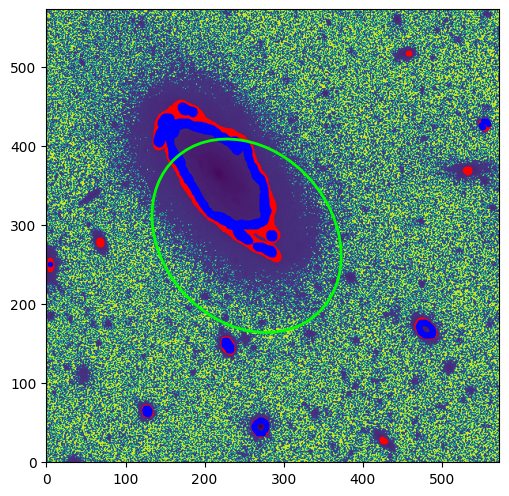

In [18]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
plt.imshow(mag, origin='lower')
plt.plot(contour_u.T[0], contour_u.T[1], 'r.')
plt.plot(contour_l.T[0], contour_l.T[1], 'b.')
ell_patch1 = Ellipse((xc, yc), 2*a, 2*b, np.rad2deg(theta), edgecolor='lime', facecolor='none', zorder=10, lw=2)
ax.add_patch(ell_patch1)


# ax.set_xlim([200, 420])
# ax.set_ylim([200, 420])

In [19]:
def ellipse_eqn(phi, xc, yc, a, b, theta):
    x = a*np.cos(phi)*np.cos(theta) - b*np.sin(phi)*np.sin(theta) + xc
    y = a*np.cos(phi)*np.sin(theta) + b*np.sin(phi)*np.cos(theta) + yc
    return x, y

def coord_in(x, y):
    return np.where((contour.T[0] == x) & (contour.T[1] == y))

def get_nearest1(xi, yi):
    vec0 = np.array([-1, 0])
    veci = np.array([xi, yi]) - np.mean(contour, axis=0)
    ni = np.linalg.norm(veci)
    ang = np.arccos(np.dot(veci, vec0)/ni)
    sign = -np.sign(np.arcsin(np.cross(veci,vec0)/ni))
    return sign*ang, ni

def unravel1(data):
    res_thetas = np.vectorize(get_nearest1)(data.T[0], data.T[1])
    res_thetas = res_thetas + abs(np.min(res_thetas))
    return res_thetas

In [20]:
full_ur1 = unravel1(contour)
ind_u = [int(coord_in(x, y)[0]) for x, y in contour_u]
ind_l = [int(coord_in(x, y)[0]) for x, y in contour_l]
xu, yu = full_ur1[0][ind_u], full_ur1[1][ind_u]
xl, yl = full_ur1[0][ind_l], full_ur1[1][ind_l]


In [21]:
def mirror(x):
    theta_bin_low = yl[np.where(xlr == x)]
    theta_bin_upp = yu[np.where(xur == x)]
    return 2*theta_bin_upp.min() - theta_bin_low.min()

def check_width(x):
    theta_bin_low = yl[np.where(xlr == x)]
    theta_bin_upp = yu[np.where(xur == x)]
    return theta_bin_upp.max() - theta_bin_low.min()

resol_ = 1
xur, xlr = np.round(full_ur1[0][ind_u], resol_), np.round(full_ur1[0][ind_l], resol_)
r_ang = np.unique(np.intersect1d(xur, xlr))
vals = np.vectorize(mirror)(r_ang)
widths = np.vectorize(check_width)(r_ang)

In [22]:
def cuts(bin, keep):
    ind = np.where(r_ang == bin)[0]
    targs = np.where(xur == bin)
    check = yu[targs] > vals[ind] if keep else yu[targs] <= vals[ind]
    return targs[0][np.where(check)]

In [23]:
red_inds = np.concatenate([cuts(bin, True) for bin in r_ang])
green_inds = np.concatenate([cuts(bin, False) for bin in r_ang])
len(xl), len(xu), len(xu) - len(xu[red_inds])

(3170, 3638, 1597)

In [24]:
np.std(vals), np.mean(vals), 

(18.68830523054767, 64.87101236026999)

In [25]:
peaks_ = find_peaks(vals, distance=len(vals)/4)[0]
peaks_

array([ 1, 23, 57], dtype=int64)

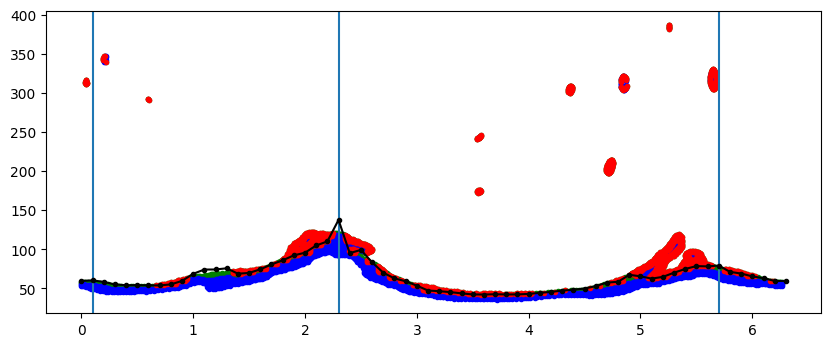

In [26]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.plot(xu, yu, 'g.')
ax.plot(xl, yl, 'b.')


ax.plot(r_ang, vals, 'k.-', zorder=10)
ax.plot(xu[red_inds], yu[red_inds], 'r.')
for pk in peaks_:
    ax.axvline(r_ang[pk])

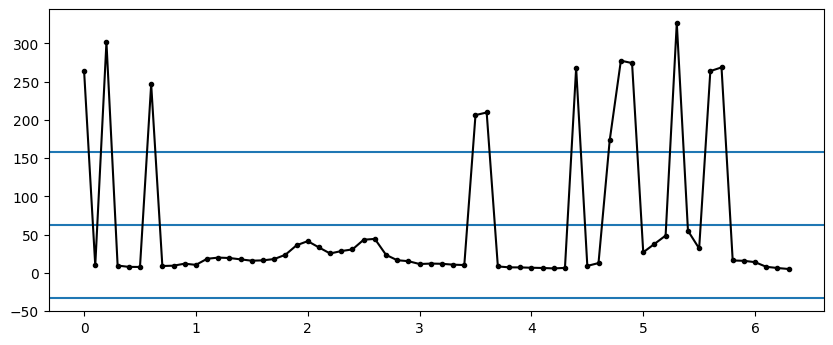

In [27]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.plot(r_ang, widths, 'k.-', zorder=10)
ax.axhline(np.mean(widths))
ax.axhline(np.mean(widths)+np.std(widths))
ax.axhline(np.mean(widths)-np.std(widths))

In [28]:
px_dg = np.concatenate([contour_u[green_inds], contour_l])
ellg = EllipseModel()
ellg.estimate(px_dg)
resg = ellg.residuals(px_dg)
xcg, ycg, ag, bg, thetag =  ellg.params

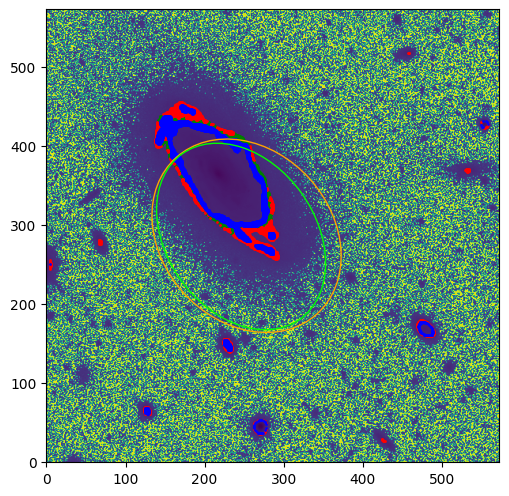

In [29]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
plt.imshow(mag, origin='lower')
plt.plot(contour_u[green_inds].T[0], contour_u[green_inds].T[1], 'g.', ms=2)
plt.plot(contour_u[red_inds].T[0], contour_u[red_inds].T[1], 'r.', ms=2)
plt.plot(contour_l.T[0], contour_l.T[1], 'b.', ms=2)

ell_patch1 = Ellipse((xc, yc), 2*a, 2*b, np.rad2deg(theta), edgecolor='orange', facecolor='none', zorder=10, lw=1)
ax.add_patch(ell_patch1)

ell_patch1g = Ellipse((xcg, ycg), 2*ag, 2*bg, np.rad2deg(thetag), edgecolor='lime', facecolor='none', zorder=10, lw=1)
ax.add_patch(ell_patch1g)


# ax.set_xlim([120, 250])
# ax.set_ylim([110, 220])

In [1719]:
def get_nearest(xi, yi):
    vec0 = ellipse_eqn(0, *ellg.params)
    veci = np.array([xi-xcg, yi-ycg])
    n0 = np.linalg.norm(vec0)
    ni = np.linalg.norm(veci)
    ang = np.arccos(np.dot(veci, vec0)/(ni*n0))
    sign = -np.sign(np.arcsin(np.cross(veci,vec0)/(ni*n0)))
    ang_ = np.arctan(bg/ag * np.tan(ang))
    
    if (ang >= 0) & (ang < np.pi/2):
        ang_c = sign*ang_
    else:
        ang_c = np.pi+sign*ang_
    return ang_c

def inside_ellipse(x, y, params):
    xc, yc, a, b, theta = params
    term1 = np.cos(theta)*(x - xcg) + np.sin(theta)*(y - yc)
    term2 = np.sin(theta)*(x - xcg) - np.cos(theta)*(y - yc)
    return term1**2/a**2 + term2**2/b**2 >= 1

def unravel(data):
    res_thetas = np.vectorize(get_nearest)(data.T[0], data.T[1])
    res_thetas = res_thetas + abs(np.min(res_thetas))
    res_signs = inside_ellipse(data.T[0], data.T[1], ellg.params)*2-1
    return res_thetas, resg * res_signs

In [1720]:
full_ur = unravel(px_dg)

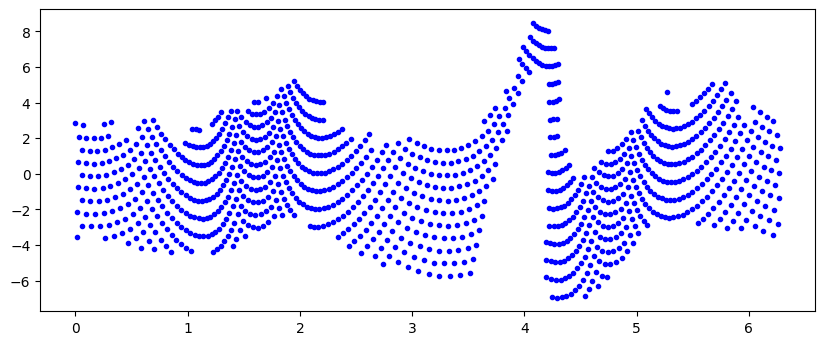

In [1721]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.plot(full_ur[0], full_ur[1], 'b.')

In [7]:
sn_name = 'ZTF20acwmpsj'#, ZTF20acyybvq ,ZTF19abzhfjj 
# sn_name = targets[np.random.randint(0, len(targets))]
gd = galaxy_decomp(sn_name, verbose=True, band='g', source='save')

ZTF20acwmpsj 122.91033 -2.3300799999999997 0.051820000000000005 z_gal
legacy 264 0.262


[0.16719428 0.22429987 0.07586196]


(<AxesSubplot:>, <AxesSubplot:>)

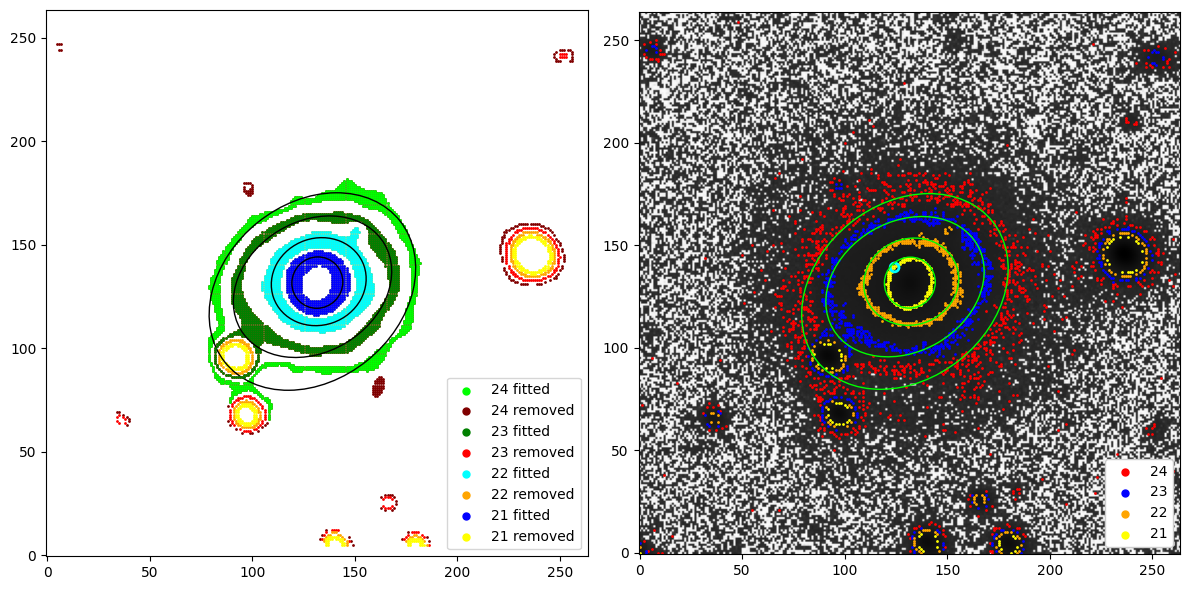

In [8]:
out_par, out_data, obj = gd.main_run(mask=False)
gd.plot_fit(out_par, out_data, obj)

[0.1027141  0.10207335 0.07586196]


(<AxesSubplot:>, <AxesSubplot:>)

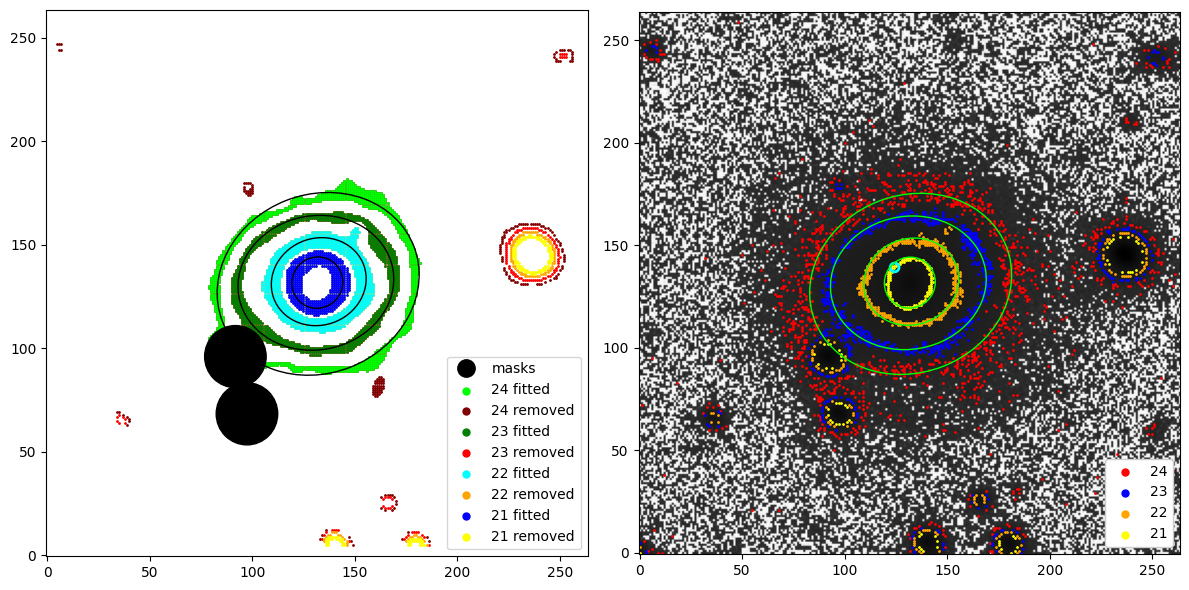

In [9]:
out_par, out_data, obj = gd.main_run(mask=True)
gd.plot_fit(out_par, out_data, obj)

In [913]:
def inside_ellipse(x, y, params):
    xc, yc, a, b, theta = params
    term1 = np.cos(theta)*(x - xc) + np.sin(theta)*(y - yc)
    term2 = np.sin(theta)*(x - xc) - np.cos(theta)*(y - yc)
    return term1**2/a**2 + term2**2/b**2 >= 1

i_ = 2
res_signs = inside_ellipse(out_data[i_][1].T[0], out_data[i_][1].T[1], out_par[i_][:5])*2-1
pd.Series(out_data[i_][2]*res_signs).hist(bins=20)

In [ ]:
# make stats of offset hosts
# update dr2 for new redshifts
# spiral arm fit